<a href="https://colab.research.google.com/github/Menwagaw/CEU_CEN/blob/main/ML_FINAL_Oct02_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Title: Supervised Machine Learning for Predicting Wildfire Occurrence and Burn Severity

**Case Study: January 2025 Los Angeles Fires**


**Submitted by**: Menwagaw T.
*Date*: June 2025

In partial fulfilment of the course: Machine Learning Methods for Engineering Applications [063060]

**Supervisors**: Prof. Beatrice Cantoni & Prof. Francesco Trovò




# Summary of the Project

This project aims to predict wildfire Ocurrence and  burn severity using the RdNBR index derived from MODIS Surface Reflectance data for the January 2025 wildfire in Los Angeles County, Southern California. Machine learning models are trained on a comprehensive set of predictors, including pre-fire weather from ERA5-Land (temperature, wind, soil moisture, precipitation), terrain attributes from SRTM (slope, aspect, elevation), soil properties from SoilGrids, vegetation metrics from MODIS and LANDFIRE (NDVI anomalies, structure), and urban factors such as population and road density. Permanent water bodies are excluded using the JRC Global Surface Water mask. These integrated variables enable robust modeling of post-fire severity patterns.

#Key Activities

1. Classification of fire severity classes using ML classifiers

2. Regression modeling of continuous RdNBR severity values

3. Optimization and validation of ML models for enhanced prediction accuracy (working with optimal model)

#-----------------------------------

#**PART I**

#-----------------------------------


# DATA COLLECTION, HARMONIZATION, AND PREPROCESSING





# Objectives

1. Classification: Wildfire occurrence (multi-class: no-fire/low/moderate/high risk)

2. Regression: Wildfire severity (e.g., RdNBR)

# Data Access and Retrieve

Multi-sources of data were accessed using GEE python API ( I can provide as necessary). Then, harmonization of  multi-source spatiotemporal predictors of the following were performed:

* **Weather**: temperature, wind speed, RH, precipitation (CHIRPS, ERA5)
* **Vegetation**: NDVI, EVI, land cover (MODIS, ESA WorldCover, LANDFIRE)
* **Topography**: slope, elevation, aspect (SRTM/DEM)
* **Soil**: moisture, texture (SoilGrids)
* **Urban Features**: distance to roads, population density
* **Fire history**: MODIS burned area,500m)

Window of timing for predictors were appropriately and logically determined.
Target variables:

a) Classification: Fire occurrence ( multi-class severity level)

b) Regression: Fire severity (e.g., RdNBR)


#Data Preprocessing

1) Derivation of variables: target variables (occurence and severity) as well as some predictors such as VPD and RH were coputed using other parameters.Furthermore, temperature and NDVI anomalies were computed., and taken as additional predictors.

2) Stack predictors and combine with target variables. Scenarios were performed to harmonizatize the spatial resolution of sampling (no significant impact in prediction. We tested 250, 30, 500m and finaly took 500m, monthly).

3) Normalization: standardize data ( standardize scale)
4) Data split: partitioned into training(80%) and test(20%) sets





# Target Variables

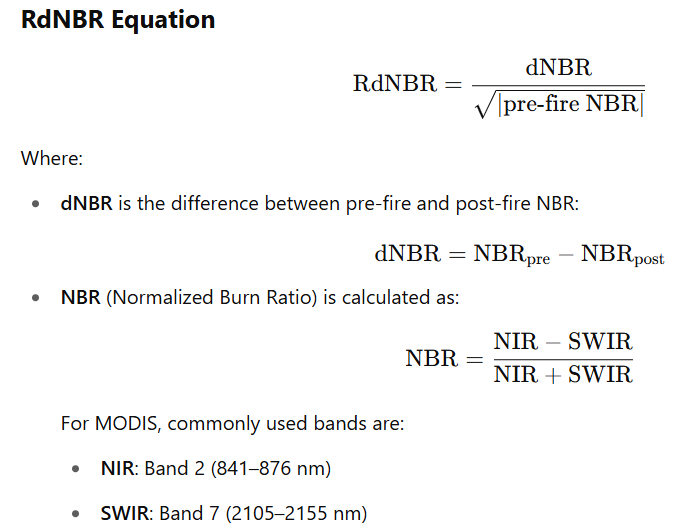



## USGS Standard RdNBR Thresholds for Fire Severity : Miller & Thode (2007)

| **RdNBR Range** | **Class**         | **Description**                       |
| --------------- | ----------------- | ------------------------------------- |
| `< 0.0`         | 0 – Unburned      | No fire or post-fire regrowth         |
| `0.0 – 0.27`    | 1 – Low Severity  | Minimal vegetation change             |
| `0.27 – 0.44`   | 2 – Moderate-Low  | Partial canopy and surface burn       |
| `0.44 – 0.66`   | 3 – Moderate-High | Canopy and understory burn            |
| `> 0.66`        | 4 – High Severity | Severe canopy consumption, total burn |


#Access Data from GEE platform with Python API

In [1]:

# Install required libraries
!pip install earthengine-api xgboost lightgbm shap geemap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00


In [2]:
# Import libraries
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-menwagaw') # my GEE project ID

#Define Fire occurence, compute Fire Severity (RdNBR) , and  mask water bodies

In [87]:

# Define AOI (Southern California, LA area where the palisades+Eaton fires happened)

AOI= ee.Geometry.Rectangle([-118.87, 33.97, -117.98, 34.40])

# Fire dates
start_date = '2025-01-07'
end_date = '2025-01-14'

# Time windows
pre_start = ee.Date(start_date).advance(-14, 'day')
pre_end = ee.Date(start_date)
post_start = ee.Date(end_date)
post_end = ee.Date(end_date).advance(14, 'day')

# Water mask
water_mask = ee.Image("JRC/GSW1_4/GlobalSurfaceWater") \
    .select("occurrence") \
    .gt(10) \
    .clip(AOI) \
    .unmask(0)

# Define target variable
def getRdNBR(AOI, start_date, end_date, water_mask):
    # Time windows
    pre_start = ee.Date(start_date).advance(-14, 'day')
    pre_end = ee.Date(start_date)
    post_start = ee.Date(end_date)
    post_end = ee.Date(end_date).advance(14, 'day')

    # Load MODIS reflectance
    modis = (
        ee.ImageCollection("MODIS/061/MOD09GA")
        .filterBounds(AOI)
        .filterDate(pre_start, post_end)
        .select(['sur_refl_b02', 'sur_refl_b07'])  # NIR and SWIR
    )

    # Pre- and post-fire composites
    preFire = modis.filterDate(pre_start, pre_end).median().clip(AOI)
    postFire = modis.filterDate(post_start, post_end).median().clip(AOI)

    # Compute NBR
    def compute_nbr(image):
        return image.normalizedDifference(['sur_refl_b02', 'sur_refl_b07']).rename('NBR')

    preNBR = compute_nbr(preFire)
    postNBR = compute_nbr(postFire)

    # Compute RdNBR
    dNBR = preNBR.subtract(postNBR).rename('dNBR')
    RdNBR = dNBR.divide(preNBR.abs().sqrt()).rename('RdNBR')

    # Mask water areas
    RdNBR_Target = RdNBR.updateMask(water_mask.Not())

    return RdNBR_Target



#Classify Fire severity using thresholds

In [90]:
# 🔻 Classify RdNBR into severity levels
# Thresholds from USGS RdNBR fire severity guidelines
def classify_rdnbr(image):
    classified = (
        image
        .where(image.lt(0.0), 0)       # Unburned
        .where(image.gte(0.0).And(image.lt(0.27)), 1)   # Low
        .where(image.gte(0.27).And(image.lt(0.44)), 2)  # Moderate-low
        .where(image.gte(0.44).And(image.lt(0.66)), 3)  # Moderate-high
        .where(image.gte(0.66), 4)     # High
    )
    return classified.toInt().rename('severity') # Ensure integer type and rename

# Call the getRdNBR function to define RdNBR_Target
RdNBR_Target = getRdNBR(AOI, start_date, end_date, water_mask)

# Apply classification and rename the band
RdNBR_classified = classify_rdnbr(RdNBR_Target)


# Severity palette with corrected hex colors (# prefix)
severity_palette = [
    '#d3d3d3',  # 0: Unburned (gray)
    '#ffff00',  # 1: Low Severity (yellow)
    '#ff7f00',  # 2: Moderate-Low Severity (orange)
    '#ff0000',  # 3: Moderate-High Severity (red)
    '#8b0000',  # 4: High Severity (dark red)
]

# Create the map centered on the AOI
Map = geemap.Map(center=[34.2, -118.4], zoom=10)

Map.addLayer(RdNBR_classified, {
    'min': 0,
    'max': 4,
    'palette': severity_palette
}, 'Classified RdNBR Severity')

#Map.addLayer(water_mask.selfMask(), {'palette': ['blue']}, 'Water Mask')

# Add legend for severity classes
legend_dict = {
    'Unburned': '#d3d3d3',
    'Low Severity': '#ffff00',
    'Moderate-Low': '#ff7f00',
    'Moderate-High': '#ff0000',
    'High Severity': '#8b0000'
}

Map.add_legend(title="Fire Severity (RdNBR)", legend_dict=legend_dict)

Map

Map(center=[34.2, -118.4], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

#Acces and derive Predictor variables

Literature often uses 1-4 weeks before ignition as a predictor window for fire severity models.

To predict RdNBR for the January 2025 (Jan 7-14) California fire, either we use  short-term fire-weather condition (Jan 1-6) or and medium-term  (Dec 24-Jan 6) cumulative fuel dryness and precipitation effects.

In [116]:
print(task.status())

{'state': 'COMPLETED', 'description': 'Dec2024_Precip_Anomaly', 'priority': 100, 'creation_timestamp_ms': 1759330749649, 'update_timestamp_ms': 1759330759159, 'start_timestamp_ms': 1759330757989, 'task_type': 'EXPORT_FEATURES', 'destination_uris': ['https://drive.google.com/'], 'attempt': 1, 'batch_eecu_usage_seconds': 0.013796050101518631, 'id': 'HQJAYFAGI2AEG32AMXTW2MO2', 'name': 'projects/ee-menwagaw/operations/HQJAYFAGI2AEG32AMXTW2MO2'}


In [105]:
# ----------------------------------------------
# 1.0 Setup & Utility Functions
# ----------------------------------------------

# Define AOI
AOI = ee.Geometry.Rectangle([-118.87, 33.97, -117.98, 34.40])

# Define date ranges (LA fire in Jan 2025)
weatherStartDate = '2024-12-24'
weatherEndDate   = '2025-01-06'
fireStartDate    = '2025-01-07'
fireEndDate      = '2025-01-14'

# Water mask (exclude water bodies)
waterMask = ee.Image("JRC/GSW1_4/GlobalSurfaceWater") \
    .select("occurrence").gt(10).clip(AOI).unmask(0)

def maskWater(image):
    return image.updateMask(waterMask.Not())

def clip_mask_rename(image, new_name):
    """Clip, mask water, and rename in one step."""
    return image.clip(AOI).updateMask(waterMask.Not()).rename(new_name)


In [106]:
# 1.1 Weather Variables (Prefire + Anomalies)

def getSelectedWeatherVars():
    # Prefire ERA5 collection
    era5_prefire = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .filterDate(weatherStartDate, weatherEndDate) \
        .filterBounds(AOI)

    # --- Wind Speed Max ---
    windSpeedMax = era5_prefire.map(
        lambda img: img.select('u_component_of_wind_10m').pow(2)
        .add(img.select('v_component_of_wind_10m').pow(2)).sqrt()
    ).max().rename('windSpeedMax').clip(AOI)

    # --- Total Precip (sum: m → mm) ---
    totalPrecip = era5_prefire.select('total_precipitation_sum') \
        .reduce(ee.Reducer.sum()) \
        .multiply(1000) \
        .rename('totalPrecip_mm') \
        .clip(AOI)

    # --- Mean Temperature (K → °C) ---
    tempMean = era5_prefire.select('temperature_2m') \
        .mean().subtract(273.15) \
        .rename('tempMean_C') \
        .clip(AOI)

    # --- Dewpoint Temp (K → °C, for VPD) ---
    dewpointMean = era5_prefire.select('dewpoint_temperature_2m') \
        .mean().subtract(273.15) \
        .rename('dewpointMean_C') \
        .clip(AOI)

    # --- Derive Vapor Pressure Deficit (VPD, kPa) ---
    T, Td = tempMean, dewpointMean
    es = T.multiply(17.27).divide(T.add(237.3)).exp().multiply(0.6108)
    ea = Td.multiply(17.27).divide(Td.add(237.3)).exp().multiply(0.6108)
    vpd = es.subtract(ea).rename('VPD_kPa')

    # --- Soil Moisture Min (m³/m³, no conversion) ---
    soilMoistureMin = era5_prefire.select('volumetric_soil_water_layer_1') \
        .reduce(ee.Reducer.min()) \
        .rename('soilMoistureMin_m3m3') \
        .clip(AOI)

    #-----------------------------------------------------------

    # --- December Precip Anomaly ---
def getDecemberPrecipAnomaly(AOI):
    # December 2024: total precip (m → mm)
    dec2024 = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
        .filterDate('2024-12-01', '2024-12-31') \
        .filterBounds(AOI) \
        .select('total_precipitation_sum') \
        .sum() \
        .multiply(1000) \
        .rename('Dec2024_total_mm') \
        .clip(AOI)

    # Baseline 2015–2023: average of Dec totals
    def yearly_dec_total(year):
        start = ee.Date.fromYMD(year, 12, 1)
        end   = start.advance(1, 'month')
        return ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
            .filterDate(start, end) \
            .filterBounds(AOI) \
            .select('total_precipitation_sum') \
            .sum() \
            .set('year', year)

    baseline_years = ee.List.sequence(2015, 2023)
    dec_totals = ee.ImageCollection(baseline_years.map(yearly_dec_total))

    decClim = dec_totals.mean().multiply(1000).rename('DecClim_total_mm').clip(AOI)

    # Anomaly = Dec 2024 total - baseline avg total
    precipAnom = dec2024.subtract(decClim).rename('precipAnom_mm')

    return precipAnom

   #------------------------------------------------------------

    # --- Soil Moisture Anomaly ---
    soil_moist_2024 = dec_2024.select('volumetric_soil_water_layer_1').mean()
    soil_moist_baseline = baseline_mean.select('volumetric_soil_water_layer_1')
    soilMoistAnom = soil_moist_2024.subtract(soil_moist_baseline).rename('soilMoistAnom_m3m3')

    # --- VPD Anomaly ---
    def calculateVPD(collection):
        """Calculate VPD from a collection"""
        mean_img = collection.mean()
        T = mean_img.select('temperature_2m').subtract(273.15)
        Td = mean_img.select('dewpoint_temperature_2m').subtract(273.15)
        es = T.multiply(17.27).divide(T.add(237.3)).exp().multiply(0.6108)
        ea = Td.multiply(17.27).divide(Td.add(237.3)).exp().multiply(0.6108)
        return es.subtract(ea)

    vpd_2024 = calculateVPD(dec_2024)
    vpd_baseline = calculateVPD(baseline_collection)
    vpdAnom = vpd_2024.subtract(vpd_baseline).rename('VPD_Anom_kPa')

    # Print some diagnostics to check if images have spatial variability
    print('Checking anomaly spatial variability...')

    # Test if images have multiple values
    def checkSpatialVariability(image, name):
        stats = image.reduceRegion(
            reducer=ee.Reducer.minMax(),
            geometry=AOI,
            scale=1000,
            bestEffort=True
        )
        min_val = stats.get(f'{name}_min').getInfo()
        max_val = stats.get(f'{name}_max').getInfo()
        print(f'{name}: min={min_val}, max={max_val}')
        return min_val != max_val  # Returns True if there's spatial variation

    # Check each anomaly
    checkSpatialVariability(tempAnom, 'tempAnom_C')
    checkSpatialVariability(precipAnom, 'precipAnom_mm')
    checkSpatialVariability(soilMoistAnom, 'soilMoistAnom_m3m3')
    checkSpatialVariability(vpdAnom, 'VPD_Anom_kPa')

    # Final weather stack
    weather_stack = ee.Image.cat([
        windSpeedMax, totalPrecip, tempMean, vpd, soilMoistureMin,
        tempAnom, precipAnom, soilMoistAnom, vpdAnom
    ]).updateMask(waterMask.Not())

    return weather_stack

In [107]:
#1.2 Vegetation condition, and Urban Features

def getVegUrbanFeatures():
    # === NDVI Fuel Moisture (Dec 24–Jan 6, 2025) ===
    fuel_ndvi = ee.ImageCollection('MODIS/061/MOD13Q1') \
        .filterBounds(AOI) \
        .filterDate(weatherStartDate, weatherEndDate) \
        .select('NDVI').mean().multiply(0.0001).rename('Fuel_NDVI')

    # === Baseline NDVI (Decembers 2015–2023) ===
    baseline_ndvi = ee.ImageCollection('MODIS/061/MOD13Q1') \
        .filterBounds(AOI) \
        .filterDate('2015-01-01', '2023-12-31') \
        .filter(ee.Filter.calendarRange(12, 12, 'month')) \
        .select('NDVI').mean().multiply(0.0001)

    # === NDVI Anomaly (Fuel NDVI - Baseline NDVI)
    fuel_ndvi_anom = fuel_ndvi.subtract(baseline_ndvi).rename('Fuel_NDVI_Anom')

    # Urban features
    popDensity = clip_mask_rename(
        ee.ImageCollection("CIESIN/GPWv411/GPW_Population_Density")
        .filterBounds(AOI).first().select("population_density"), "popDensity")

    # --- Corrected Road Density generation ---
    # Use countEvery to handle overlapping lines and specify scale/projection
    roadDensity = ee.FeatureCollection("projects/sat-io/open-datasets/GRIP4/North-America") \
        .filterBounds(AOI) \
        .reduceToImage(
            properties=['scalerank'], # Property to reduce (can be anything, we just need count)
            reducer=ee.Reducer.countEvery() # Count overlapping features
            # Removed scale argument from reduceToImage
        ) \
        .reproject(crs='EPSG:4326', scale=500) \
        .rename('roadDensity') \
        .clip(AOI) \
        .updateMask(waterMask.Not()) # Apply water mask


    # Vegetation structure
    # Ensure these are also clipped and masked if the functions don't already
    vegCover  = clip_mask_rename(ee.ImageCollection("LANDFIRE/Vegetation/EVC/v1_4_0").filterBounds(AOI).first(), "vegCover")
    vegType   = clip_mask_rename(ee.ImageCollection("LANDFIRE/Vegetation/EVT/v1_4_0").filterBounds(AOI).first(), "vegType")
    vegHeight = clip_mask_rename(ee.ImageCollection("LANDFIRE/Vegetation/EVH/v1_4_0").filterBounds(AOI).first(), "vegHeight")


    return ee.Image.cat([
        fuel_ndvi, fuel_ndvi_anom,
        popDensity, roadDensity,
        vegCover, vegType, vegHeight
    ])

In [108]:

# 1.3 Topographic Features (SRTM)
def getTopographicFeatures():
    dem = ee.Image("USGS/SRTMGL1_003").clip(AOI).resample('bilinear')
    elevation = clip_mask_rename(dem.select('elevation'), "elevation")
    terrain   = ee.Terrain.products(dem)
    slope     = clip_mask_rename(terrain.select('slope'), "slope")
    aspect    = clip_mask_rename(terrain.select('aspect'), "aspect")

    return ee.Image.cat([elevation, slope, aspect])


# 1.4 Soil Properties (SoilGrids)

def getSoilProperties():
    soilCarbon      = clip_mask_rename(ee.Image('projects/soilgrids-isric/ocs_mean').select(0), "soilCarbon")
    soilSand        = clip_mask_rename(ee.Image('projects/soilgrids-isric/sand_mean').select(0).divide(10), "soilSand")
    soilClay        = clip_mask_rename(ee.Image('projects/soilgrids-isric/clay_mean').select(0).divide(10), "soilClay")
    soilBulkDensity = clip_mask_rename(ee.Image('projects/soilgrids-isric/bdod_mean').select(0).divide(100), "soilBulkDensity")

    return ee.Image.cat([soilCarbon, soilSand, soilClay, soilBulkDensity])


#Combine datasets, Determine sample size and Export Data as CSV

In [109]:
# --- Predictor stack ---
weather_vars = getSelectedWeatherVars()
veg_urban_features = getVegUrbanFeatures()
topographic_features = getTopographicFeatures()
soil_properties = getSoilProperties()

predictors = ee.Image.cat(
    weather_vars,
    veg_urban_features,
    topographic_features,
    soil_properties
)

# --- Target variables ---
# Continuous burn severity (regression)
RdNBR_Target = getRdNBR(AOI, fireStartDate, fireEndDate, waterMask).rename('RdNBR')

# Classified burn severity (categorical)
RdNBR_classified = classify_rdnbr(RdNBR_Target).rename('RdNBR_class')

# --- Final stack (predictors + both targets) ---
stack = predictors.addBands([RdNBR_Target, RdNBR_classified])


In [110]:
#Determine sample size (30% was considered)

#Inspect class distribution in the AOI to determine
# Count pixels per class
counts = RdNBR_classified.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=AOI,
    scale=500,
    maxPixels=1e9
)
print(counts.getInfo())


{'RdNBR_class': {'0': 7042.317647058841, '1': 9403.84313725492, '2': 421.70980392156866, '3': 329.99607843137255, '4': 296.2470588235294}}


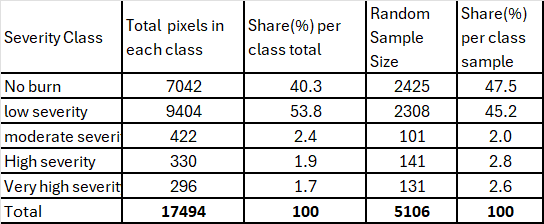

Although 10,000 sample points were requested, only 5,106 were obtained,approximately 30% of the total pixels—which is a reasonable proportion and was used for further analysis

In [113]:
#Apply random sample size strategy

# Sample 10,000 points
samples = stack.sample(
    region=AOI,
    scale=500,
    numPixels=10000,
    geometries=True
)

# Export to CSV
task = ee.batch.Export.table.toDrive(
    collection=samples,
    description='SampleOct07',
    fileFormat='CSV'
)
task.start()

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
#Separate column of Geometry into Latitude and Longitude, and saved again

import pandas as pd
import json
import numpy as np

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/SampleOct06.csv')

# Function to safely extract longitude and latitude
def extract_lat_lon(geo_json_str):
    try:
        geo = json.loads(geo_json_str)
        if geo and 'coordinates' in geo and len(geo['coordinates']) >= 2:
            return geo['coordinates'][0], geo['coordinates'][1]
        else:
            return np.nan, np.nan # Return NaN for invalid or empty geometries
    except (json.JSONDecodeError, TypeError):
        return np.nan, np.nan # Return NaN for invalid JSON strings

# Apply the function to create new columns
df['lon'], df['lat'] = zip(*df['.geo'].apply(extract_lat_lon))

# Drop '.geo' column if not needed
df = df.drop(columns=['.geo'])

# Drop rows where latitude or longitude could not be extracted
df.dropna(subset=['lon', 'lat'], inplace=True)

# Save to new CSV
df.to_csv('/content/drive/MyDrive/DATASET_Oct02.csv', index=False)

print("Successfully extracted latitude and longitude and saved to Allsamples_lat_lon.csv")

Successfully extracted latitude and longitude and saved to Allsamples_lat_lon.csv


################################################################################

# ----------------------------------------------------

#**PART II**

#------------------------------------------------------
# STATISTICAL ANALYSIS AND ML-BASED PREDICTIVE MODELING

In [124]:
 #  Libraries and selected ML Models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
)
from sklearn.feature_selection import RFECV # Import RFECV
from sklearn.decomposition import PCA
import shap
import folium
from folium.plugins import HeatMap

# ML models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [126]:
# ------------------------------------
# PHASE 1: DATA PREPARATION AND PREPROCESSING
# ------------------------------------

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. Load your dataset with predictors + targets + latitude + longitude
df = pd.read_csv("/content/drive/MyDrive/DATASET_Oct02.csv")

# Exclude columns not used as predictors
predictor_cols = [c for c in df.columns if c not in ['lat', 'lon', 'RdNBR', 'severity', 'system:index']]

# Features and targets
X = df[predictor_cols]
y_class = df['severity']        # classification target (e.g., wildfire severity class)
y_reg = df['RdNBR']             # regression target (continuous severity)

# Coordinates for spatial analysis and visualization
coords = df[['lat', 'lon']]

# Handle missing values (drop or impute)
X = X.fillna(X.median())

# Normalize / Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


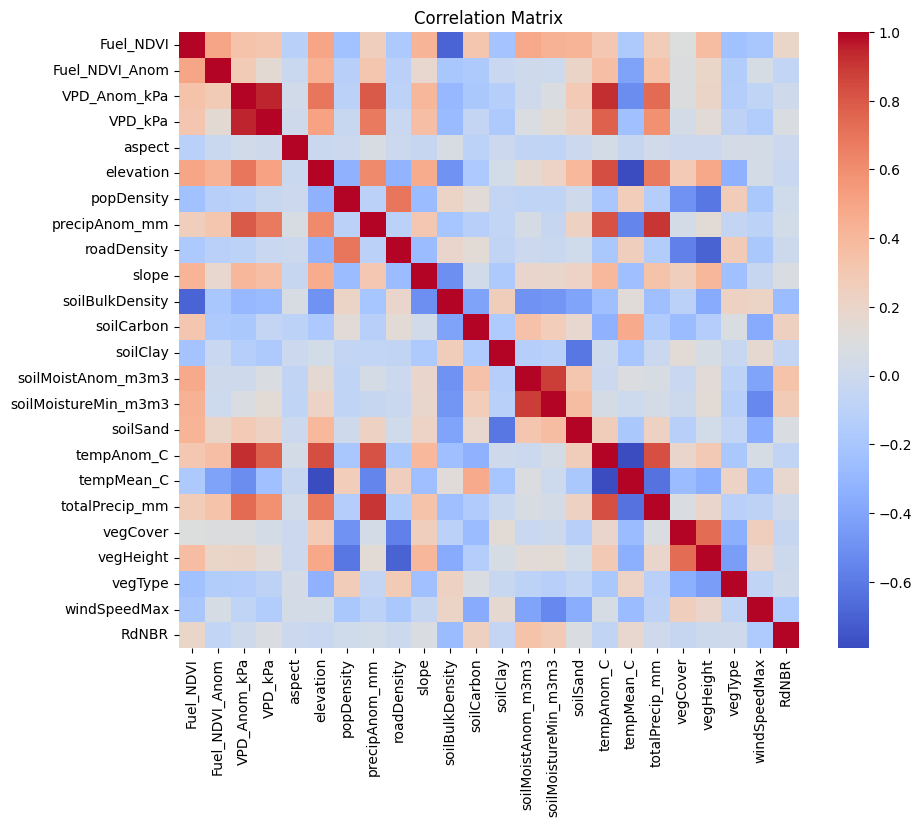

In [127]:
# ------------------------------------
# PHASE 2: EXPLORATORY ANALYSIS & FEATURE ENGINEERING
# ------------------------------------

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[predictor_cols + ['RdNBR']].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Plot variable distributions, spatial trends etc. (user-specific)



In [134]:
# ------------------------------------
# PHASE 3: FEATURE SELECTION & DIMENSIONALITY REDUCTION
# ------------------------------------

# Recursive Feature Elimination with cross-validation for classification (5-fold CV)
clf_for_rfe = RandomForestClassifier(random_state=42)
# Fit RFECV on the scaled DataFrame
rfe_clf = RFECV(estimator=clf_for_rfe, step=1, cv=5, scoring='accuracy')
rfe_clf.fit(X_scaled_df, y_class)
# Use the support mask to select columns from the scaled DataFrame
selected_features_clf = X_scaled_df.columns[rfe_clf.support_]

print("Selected features for classification (RFECV):")
for feat in selected_features_clf:
    print(f" - {feat}")

# Similarly for regression
reg_for_rfe = RandomForestRegressor(random_state=42)
# Fit RFECV on the scaled DataFrame
rfe_reg = RFECV(estimator=reg_for_rfe, step=1, cv=5, scoring='neg_mean_squared_error')
rfe_reg.fit(X_scaled_df, y_reg)
# Use the support mask to select columns from the scaled DataFrame
selected_features_reg = X_scaled_df.columns[rfe_reg.support_]

print("\nSelected features for regression (RFECV):")
for feat in selected_features_reg:
    print(f" - {feat}")

Selected features for classification (RFECV):
 - Fuel_NDVI
 - Fuel_NDVI_Anom
 - aspect
 - elevation
 - popDensity
 - slope
 - soilBulkDensity
 - soilCarbon
 - soilClay
 - soilMoistAnom_m3m3
 - soilMoistureMin_m3m3
 - soilSand
 - tempMean_C
 - vegHeight
 - vegType

Selected features for regression (RFECV):
 - Fuel_NDVI
 - Fuel_NDVI_Anom
 - aspect
 - elevation
 - popDensity
 - precipAnom_mm
 - slope
 - soilBulkDensity
 - soilCarbon
 - soilClay
 - soilMoistAnom_m3m3
 - soilSand
 - tempMean_C
 - totalPrecip_mm
 - vegCover
 - vegHeight


In [135]:
#  PCA for dimensionality reduction / visualization
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

# Display explained variance ratio of each component
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1} explains {var_ratio:.2%} of the variance")

# Also, display cumulative explained variance
print(f"Cumulative explained variance for 8 components: {pca.explained_variance_ratio_.cumsum()[-1]:.2%}")


PC1 explains 29.82% of the variance
PC2 explains 15.78% of the variance
PC3 explains 13.17% of the variance
PC4 explains 5.62% of the variance
PC5 explains 5.25% of the variance
PC6 explains 4.65% of the variance
PC7 explains 3.98% of the variance
PC8 explains 3.61% of the variance
Cumulative explained variance for 8 components: 81.87%


Number of components to explain 95% variance: 11


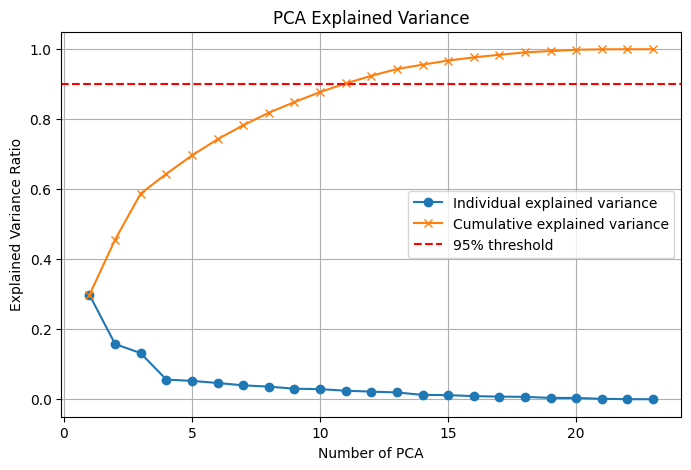

In [136]:
#To determine Number of PCA components explaining defined variance ( e.g., 90% variance)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assume X_scaled is our standardized predictor matrix: shape (5106, 20)

pca = PCA()
pca.fit(X_scaled)

# Explained variance ratio per component
explained_var = pca.explained_variance_ratio_

# Cumulative explained variance
cum_var = np.cumsum(explained_var)

# Find number of components to explain 95% variance
n_components_90 = np.argmax(cum_var >= 0.90) + 1

print(f"Number of components to explain 95% variance: {n_components_90}")

# Plot Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, marker='o', label='Individual explained variance')
plt.plot(range(1, len(cum_var)+1), cum_var, marker='x', label='Cumulative explained variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='95% threshold')
plt.xlabel('Number of PCA')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True)
plt.show()


In [137]:
# ------------------------------------
# PHASE 4: MODEL DEVELOPMENT & TRAINING
# ------------------------------------

# Train-test split (same split for both tasks)
# Select columns using the support mask from the scaled DataFrame X_scaled_df
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_scaled_df[selected_features_clf], y_class, test_size=0.2, random_state=42, stratify=y_class
)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled_df[selected_features_reg], y_reg, test_size=0.2, random_state=42
)

# Define models to compare
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier()
}

regressors = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor()
}

# Train and evaluate classifiers
clf_results = {}
for name, model in classifiers.items():
    # Check if the model is Logistic Regression (binary only)
    is_logistic_regression = isinstance(model, LogisticRegression)

    model.fit(X_train_clf, y_train_clf)
    y_pred = model.predict(X_test_clf)

    # Calculate AUC-ROC only for binary classification and models that support predict_proba
    if hasattr(model, "predict_proba") and len(np.unique(y_test_clf)) == 2:
         y_prob = model.predict_proba(X_test_clf)[:, 1]
         try:
             auc_roc = roc_auc_score(y_test_clf, y_prob)
         except ValueError:
             # Handle cases where one class is missing in the test set after stratify
             auc_roc = np.nan # Or some other indicator
             print(f"Warning: AUC-ROC could not be computed for {name} due to single class in test set.")
    else:
        y_prob = None
        auc_roc = np.nan # Not applicable or not computable


    metrics = {
        'Accuracy': accuracy_score(y_test_clf, y_pred),
        'Precision': precision_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(y_test_clf, y_pred, average='weighted', zero_division=0),
        'AUC-ROC': auc_roc
    }


    clf_results[name] = metrics

# Train and evaluate regressors
reg_results = {}
for name, model in regressors.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)

    metrics = {
        'R2': r2_score(y_test_reg, y_pred),
        'MAE': mean_absolute_error(y_test_reg, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_reg, y_pred)),
    }
    reg_results[name] = metrics

# Print results
print("\nClassification Model Results:")
clf_df = pd.DataFrame(clf_results).T
display(clf_df)

print("\nRegression Model Results:")
reg_df = pd.DataFrame(reg_results).T
display(reg_df)


Classification Model Results:


,Accuracy,Precision,Recall,F1-Score,AUC-ROC
RandomForest,0.706458,0.705047,0.706458,0.701043,NaN
XGBoost,0.680039,0.673974,0.680039,0.674849,NaN
SVM,0.665362,0.648436,0.665362,0.654316,NaN
KNN,0.649706,0.641630,0.649706,0.644786,NaN



Regression Model Results:


,R2,MAE,RMSE
LinearRegression,0.221557,0.132296,0.187544
RandomForest,0.624924,0.092592,0.130182
XGBoost,0.575395,0.097556,0.138510
SVR,0.551147,0.103161,0.142411
KNN,0.472889,0.108888,0.154327


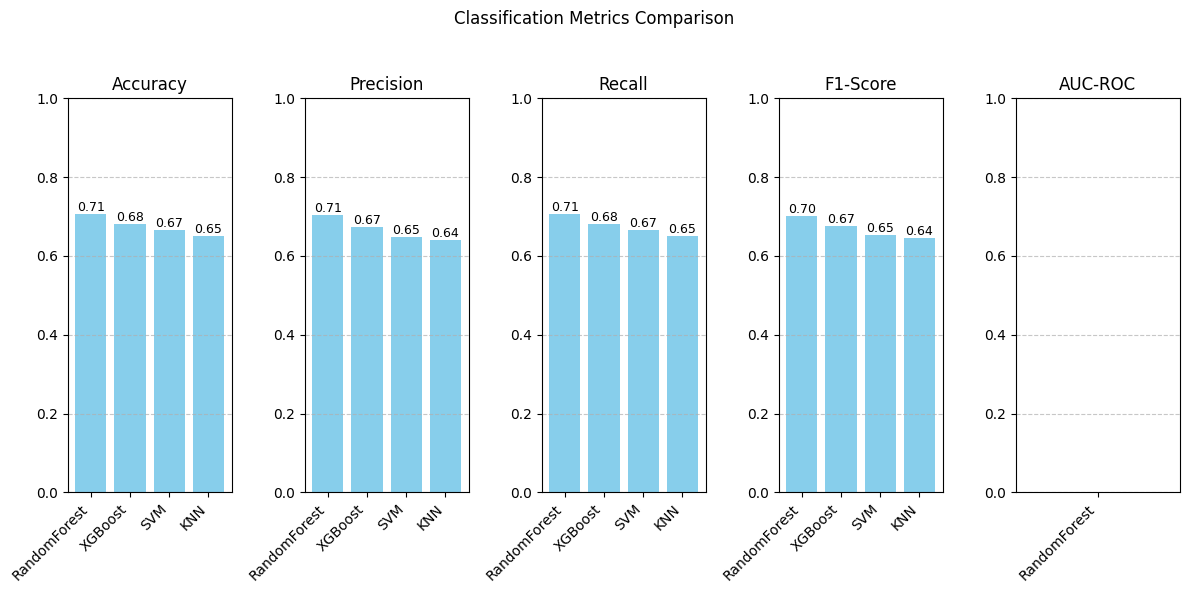

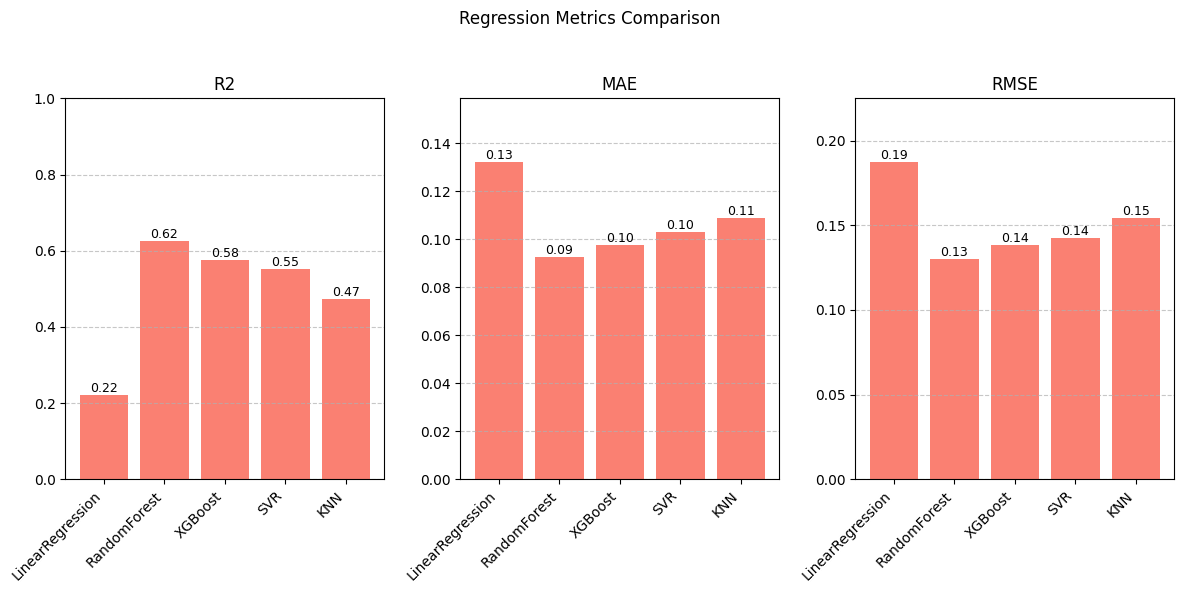

In [138]:
# Convert results dicts to DataFrames for easier plotting
clf_df = pd.DataFrame(clf_results).T  # transpose for easier plotting
reg_df = pd.DataFrame(reg_results).T

# --- Plot Classification Metrics ---
plt.figure(figsize=(12, 6))
metrics_clf = clf_df.columns.tolist()

for i, metric in enumerate(metrics_clf):
    plt.subplot(1, len(metrics_clf), i + 1)
    bars = plt.bar(clf_df.index, clf_df[metric], color='skyblue')
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1 if metric != 'AUC-ROC' else 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Label bar values
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Classification Metrics Comparison')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Plot Regression Metrics ---
plt.figure(figsize=(12, 6))
metrics_reg = reg_df.columns.tolist()

for i, metric in enumerate(metrics_reg):
    plt.subplot(1, len(metrics_reg), i + 1)
    bars = plt.bar(reg_df.index, reg_df[metric], color='salmon')
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')

    # Set y-limits dynamically for better visualization
    if metric == 'R2':
        plt.ylim(0, 1)
    else:
        plt.ylim(0, max(reg_df[metric]) * 1.2)

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Label bar values
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Regression Metrics Comparison')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#**Preliminary Findings**

In both regression and classification tasks, Random forest(RF) has slighly  outperformed (OA = 0.71, & R2 = 0.0.62). Thus, the next advanced geospatial and statistical analysis will be using RF , which is considered as optimal model


#---------------------------

#**PART III** : ADVANCED GEOSPATIAL AND STATISTICAL ANALYSIS WITH OPTIMAL  MODEL

In [139]:
# ------------------------------------
# PHASE 5: EVALUATION & INTERPRETATION (SHAP)
# ------------------------------------

# Choose best models (In the above case: RandomForest)
best_clf = classifiers['RandomForest']
best_reg = regressors['RandomForest']

# SHAP explainers
explainer_clf = shap.TreeExplainer(best_clf)
explainer_reg = shap.TreeExplainer(best_reg)

# Compute SHAP values on a sample (limit for speed)
X_sample_clf = X_test_clf[:500]
X_sample_reg = X_test_reg[:500]

shap_vals_clf = explainer_clf.shap_values(X_sample_clf, check_additivity=False)
shap_vals_reg = explainer_reg.shap_values(X_sample_reg, check_additivity=False)

# For multiclass, shap_vals_clf is a list of arrays (one per class), stack for averaging
if isinstance(shap_vals_clf, list):
    shap_vals_clf_arr = np.stack(shap_vals_clf, axis=1)  # shape (samples, classes, features)
else:
    shap_vals_clf_arr = shap_vals_clf  # binary or single output

# Aggregate absolute SHAP values across classes and features for each sample
mean_abs_shap_clf = np.abs(shap_vals_clf_arr).mean(axis=1).mean(axis=1)  # mean over classes & features

# For regression, shap_vals_reg shape (samples, features)
mean_abs_shap_reg = np.abs(shap_vals_reg).mean(axis=1)

In [142]:
# ------------------------------------
# PHASE 6: ADVANCED ANALYSIS (Spatial SHAP Overlay)
# ------------------------------------

# Rebuild spatial dataframe for sampled points (use coordinates corresponding to X_sample)
sample_indices_clf = X_test_clf[:500].index if hasattr(X_test_clf, 'index') else np.arange(500)
sample_indices_reg = X_test_reg[:500].index if hasattr(X_test_reg, 'index') else np.arange(500)

# Since X_test arrays are numpy, map back indices if possible:
# Here assuming original df indices for simplicity:
spatial_clf = coords.iloc[sample_indices_clf].copy()
spatial_reg = coords.iloc[sample_indices_reg].copy()

spatial_clf['mean_SHAP_classification'] = mean_abs_shap_clf
spatial_reg['mean_SHAP_regression'] = mean_abs_shap_reg

# Folium map setup
center_lat = coords['lat'].mean()
center_lon = coords['lon'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=7)

# Add classifier SHAP heatmap (red-yellow)
HeatMap(
    spatial_clf[['lat', 'lon', 'mean_SHAP_classification']].values.tolist(),
    name='Classifier SHAP',
    min_opacity=0.5,
    radius=15,
    blur=25,
    gradient={0.2: 'yellow', 0.5: 'orange', 1: 'red'}
).add_to(m)

# Add regression SHAP heatmap (blue shades)
HeatMap(
    spatial_reg[['lat', 'lon', 'mean_SHAP_regression']].values.tolist(),
    name='Regression SHAP',
    min_opacity=0.5,
    radius=15,
    blur=25,
    gradient={0.2: 'lightblue', 0.5: 'blue', 1: 'darkblue'}
).add_to(m)

# Add layer control to toggle heatmaps
folium.LayerControl().add_to(m)

# Display or save map
m.save('wildfire_shap_heatmaps.html')
#m



# SHAP Analysis (Classifier + Regressor)

 99%|===================| 2476/2500 [01:39<00:00]       

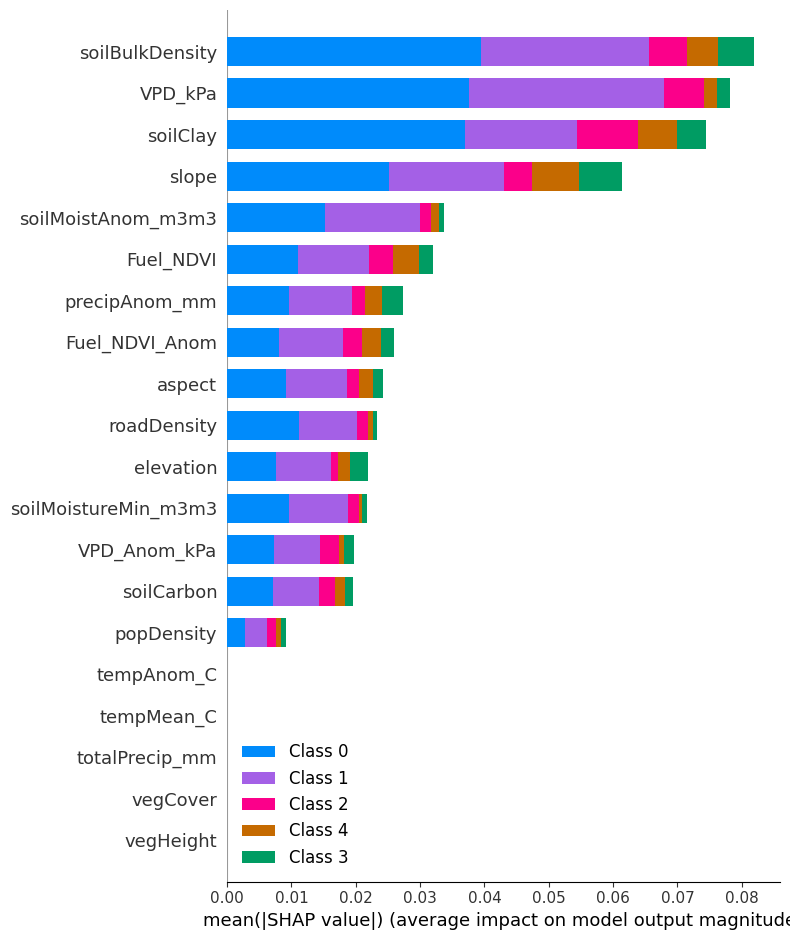

 98%|===================| 489/500 [00:37<00:00]       

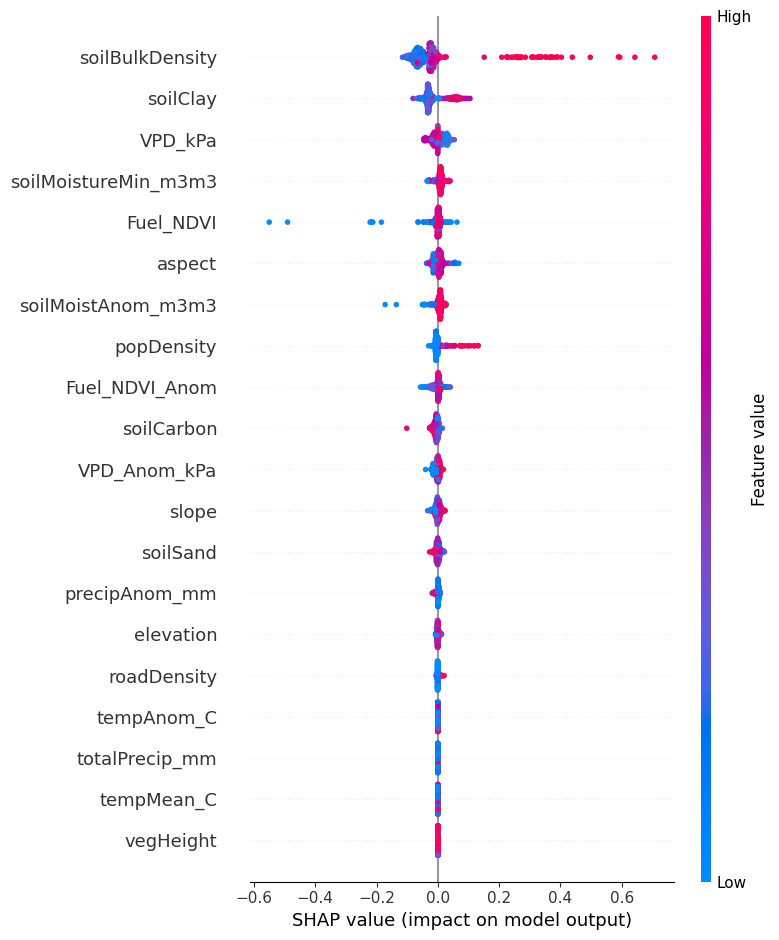

In [144]:
# Classifier SHAP
# Use the best classifier model (RandomForest)
explainer_clf = shap.Explainer(best_clf, X_scaled)
shap_vals_clf = explainer_clf(X_scaled[:500], check_additivity=False)
shap.summary_plot(shap_vals_clf, features=X.iloc[:500], feature_names=X.columns)

# Regressor SHAP
# Use the best regressor model (RandomForest)
explainer_reg = shap.Explainer(best_reg, X_scaled)
shap_vals_reg = explainer_reg(X_scaled[:500], check_additivity=False)
shap.summary_plot(shap_vals_reg, features=X.iloc[:500], feature_names=X.columns)

#  Spatial SHAP Overlay

#Spatial SHAP Overlay (Multiclass Case)

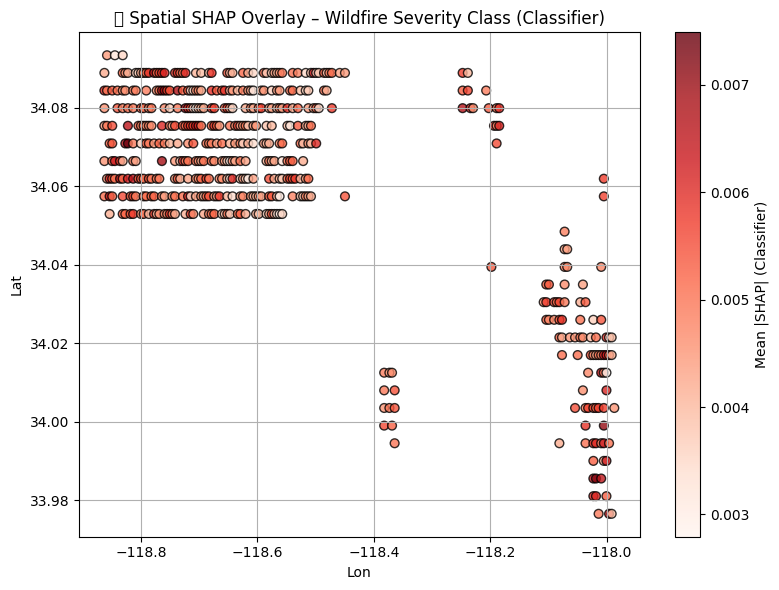

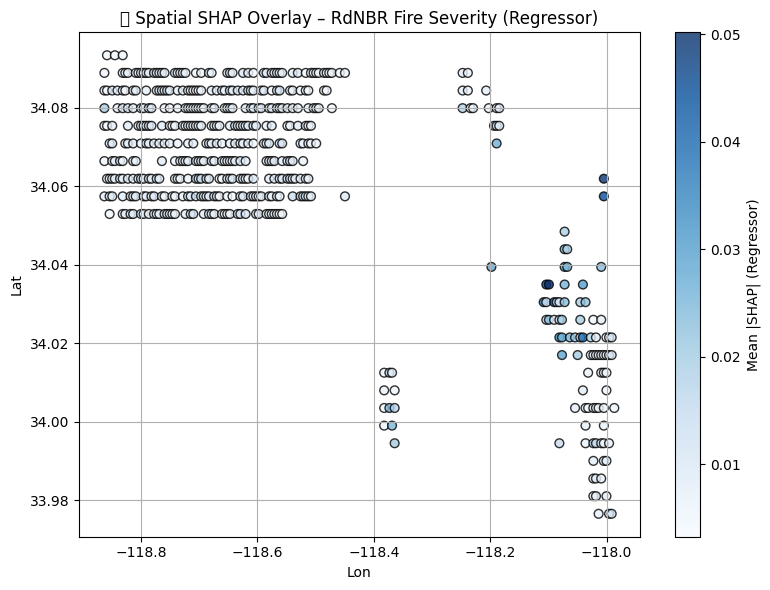

In [147]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# shap_vals_clf and shap_vals_reg are already computed with:
# shap_vals_clf = explainer_clf(X_scaled[:500], check_additivity=False)
# shap_vals_reg = explainer_reg(X_scaled[:500], check_additivity=False)
# And coords contains latitude & longitude for your samples

# --- For multiclass classification SHAP values ---
# shap_vals_clf.values shape: (n_samples, n_classes, n_features)
# Average over classes first (axis=1), then average over features (axis=1 again)
shap_vals_clf_agg = np.abs(shap_vals_clf.values).mean(axis=1)   # shape (500, n_features)
mean_abs_shap_clf = shap_vals_clf_agg.mean(axis=1)             # shape (500,)

# --- For regression SHAP values ---
# shap_vals_reg.values shape: (n_samples, n_features)
mean_abs_shap_reg = np.abs(shap_vals_reg.values).mean(axis=1)  # shape (500,)

# Prepare DataFrame with coordinates and SHAP values
spatial_df = coords.iloc[:500].copy()  # select same rows used for SHAP
spatial_df['mean_SHAP_classification'] = mean_abs_shap_clf
spatial_df['mean_SHAP_regression'] = mean_abs_shap_reg

# ---- Plot: Classification SHAP spatial overlay ----
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    spatial_df['lon'], spatial_df['lat'],
    c=spatial_df['mean_SHAP_classification'], cmap='Reds',
    s=40, edgecolor='k', alpha=0.8
)
plt.colorbar(scatter, label="Mean |SHAP| (Classifier)")
plt.title("🔥 Spatial SHAP Overlay – Wildfire Severity Class (Classifier)")
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot: Regression SHAP spatial overlay ----
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    spatial_df['lon'], spatial_df['lat'],
    c=spatial_df['mean_SHAP_regression'], cmap='Blues',
    s=40, edgecolor='k', alpha=0.8
)
plt.colorbar(scatter, label="Mean |SHAP| (Regressor)")
plt.title("🌡️ Spatial SHAP Overlay – RdNBR Fire Severity (Regressor)")
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.grid(True)
plt.tight_layout()
plt.show()


#PCA and t-SNE Dimensionality Reduction

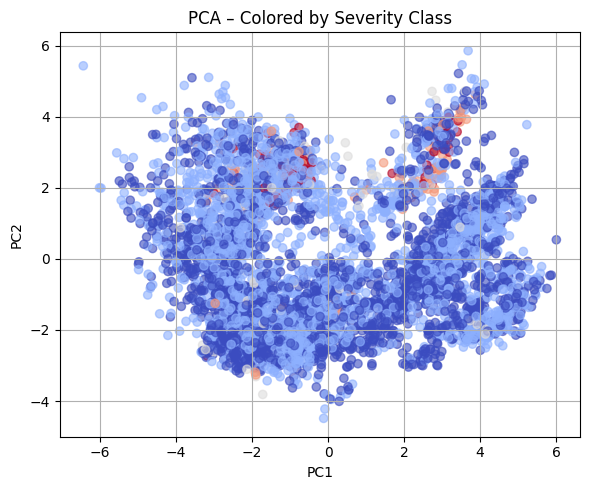

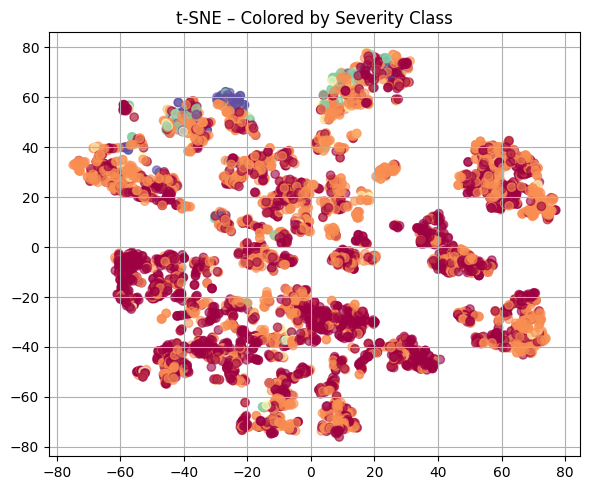

In [149]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_class, cmap='coolwarm', alpha=0.6)
plt.title("PCA – Colored by Severity Class")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_class, cmap='Spectral', alpha=0.6)
plt.title("t-SNE – Colored by Severity Class")
plt.grid(True)
plt.tight_layout()
plt.show()

#Clustering

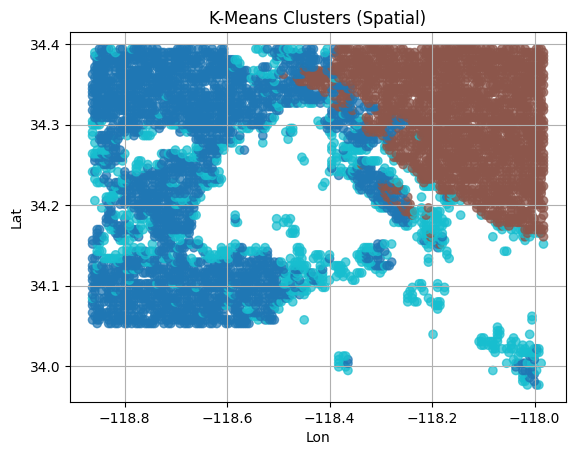

Silhouette Score: 0.241


In [150]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Choose best k (optional)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

plt.scatter(coords['lon'], coords['lat'], c=clusters, cmap='tab10', alpha=0.7)
plt.title("K-Means Clusters (Spatial)")
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.grid(True)
plt.show()

# Silhouette Score
score = silhouette_score(X_scaled, clusters)
print(f"Silhouette Score: {score:.3f}")


#Anomaly Detection (Isolation Forest)

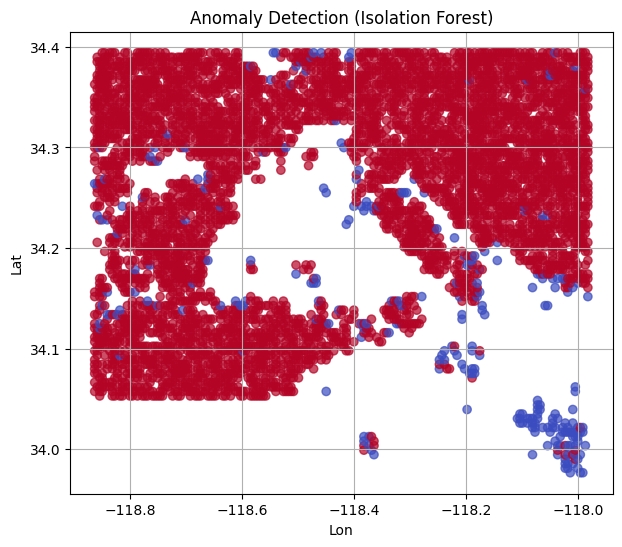

In [151]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso.fit_predict(X_scaled)

plt.figure(figsize=(7, 6))
plt.scatter(coords['lon'], coords['lat'], c=anomaly_labels, cmap='coolwarm', alpha=0.7)
plt.title("Anomaly Detection (Isolation Forest)")
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.grid(True)
plt.show()
